## Hopfield算法（矩阵版本）

In [1341]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
class HopfieldTSP():
    def __init__(self,cities,A=300,D=100,iterations=5000):
        self.cities = cities
        self.n = cities.shape[0]
        self.u0 = 0.02
        self.delta_t = 1e-4
        self.A = 300
        self.D = 100
        self.iter = iterations
        self.W = np.zeros((self.n,self.n))
        self.U = np.zeros((self.n,self.n))
        self.V = np.zeros((self.n,self.n))
        self.onevec = np.ones((self.n,1))
        self.diag = np.diag(np.ones(self.n))
        self.subdiag = np.diag(np.ones(self.n-1),k=1)
        self.subdiag[-1,0] = 1
        self.path_length = 10000000000
        self.init_params()

    def init_params(self,):
        for i in range(self.n):
            for j in range(self.n):
                self.W[i,j] = np.sqrt(np.sum((self.cities[i] - self.cities[j])**2))
        for i in range(self.n):
            for j in range(self.n):
                self.U[i,j] = 0.5 * self.u0 * np.log(self.n-1) + np.random.random() * 2-1
    
    def diff(self):
        first = np.dot(self.V,self.onevec) + np.dot(self.onevec.T,self.V) -2
        second = np.dot(self.W,np.roll(self.V,-1,axis=1))
        return -self.A*first - self.D*second
        
    def get_energy(self):
        AAT = self.A * np.dot(self.V-self.diag,self.V.T-self.diag)
        ATA = self.A * np.dot(self.V.T-self.diag,self.V-self.diag)
        constraint = np.sum(AAT) + np.sum(ATA)
        distance_matrix = np.dot(np.dot(self.V.T,self.W),self.V)*self.subdiag
        distance = np.sum(distance_matrix)*self.D
        return 0.5 * (constraint + distance)

    def check(self):
        newV = np.zeros([self.n, self.n])
        route = []
        for i in range(self.n):
            mm = np.max(self.V[:, i])
            for j in range(self.n):
                if self.V[j, i] == mm:
                    newV[j, i] = 1
                    route += [j]
                    break
        return route, newV
    
    def cal_path_length(self,path):
        path_length = 0
        for i in range(self.n-1):
            path_length += self.W[path[i],path[i+1]]
        path_length += self.W[path[-1],path[0]]
        return path_length

    def __call__(self):
        running_energy = []
        perfect_path = []
        delta_energy = 1
        iter = 0
        while delta_energy > 1e-6 :
            iter += 1
            ruote, newV = self.check()
            if len(np.unique(ruote)) == self.n:
                perfect_path = ruote
                if self.path_length > self.cal_path_length(perfect_path):
                    self.path_length = self.cal_path_length(perfect_path)
                    print("new path length: ",self.path_length)
            self.U += self.delta_t * self.diff()
            self.V = 0.5 * (1 + np.tanh(self.U / self.u0))
            energy = self.get_energy()
            # print(energy)
            delta_energy = abs(energy - running_energy[-1]) if len(running_energy) > 0 else energy
            # print(delta_energy)
            # print(f'{iter}')
            running_energy.append(energy)

        return running_energy,perfect_path,iter

## 遍历算法

In [1270]:
from itertools import permutations
class TraverseTSP():
    def __init__(self,cities) -> None:
        self.cities = cities
        self.n = cities.shape[0]
        self.W = np.zeros((self.n,self.n))
        self.path = list(range(self.n))
        self.path_length = 1000000000000
        self.init_params()

    def init_params(self):
        for i in range(self.n):
            for j in range(self.n):
                self.W[i,j] = np.sqrt(np.sum((self.cities[i] - self.cities[j])**2))
    
    def cal_path_length(self,path):
        path_length = 0
        for i in range(self.n-1):
            path_length += self.W[path[i],path[i+1]]
        path_length += self.W[path[-1],path[0]]
        return path_length

    def __call__(self):
        perfect_path = self.path.copy()
        for combo in tqdm(permutations(self.path, self.n)):  # 2 for pairs, 3 for triplets, etc
            path_length = self.cal_path_length(combo)
            if path_length < self.path_length:
                self.path_length = path_length
                perfect_path = combo
        return perfect_path


## Hopfield退火算法

In [1371]:
import numpy as np
import matplotlib.pyplot as plt
class HopfieldSATSP():
    def __init__(self,cities,iterations=3000):
        self.cities = cities
        self.n = cities.shape[0]
        self.u0 = 0.02
        self.delta_t = 1e-4
        self.A = 300
        self.D = 100
        self.W = np.zeros((self.n,self.n))
        self.U = np.zeros((self.n,self.n))
        self.V = np.zeros((self.n,self.n))
        self.iter = iterations
        self.T = 50000  # initiate temperature
        self.Tmin = 10  # minimum value of terperature
        self.path_length = 1000000000000
        self.diag = np.diag(np.ones(self.n))
        self.subdiag = np.diag(np.ones(self.n-1),k=1)
        self.subdiag[-1,0] = 1
        self.onevec = np.ones((self.n,1))
        self.ones_mat = np.ones((self.n,self.n))
        self.init_params()
        

    def init_params(self,):
        for i in range(self.n):
            for j in range(self.n):
                self.W[i,j] = np.sqrt(np.sum((self.cities[i] - self.cities[j])**2))
        self.U = 1 / 2 * self.u0 * np.log(self.n - 1) + (2 * (np.random.random((self.n, self.n))) - 1)
    
    def diff(self):
        first = np.dot(self.V,self.onevec) + np.dot(self.onevec.T,self.V) -2
        second = np.dot(self.W,np.roll(self.V,-1,axis=1))
        return -self.A*first - self.D*second
        
    def get_energy(self,V):
        AAT = self.A * np.dot(V-self.diag,V.T-self.diag)
        ATA = self.A * np.dot(V.T-self.diag,V-self.diag)
        constraint = np.sum(AAT) + np.sum(ATA)
        distance_matrix = np.dot(np.dot(V.T,self.W),V)*self.subdiag
        distance = np.sum(distance_matrix)*self.D
        return 0.5 * (constraint + distance)


    
    def check(self):
        newV = np.zeros([self.n, self.n])
        route = []
        for i in range(self.n):
            mm = np.max(self.V[:, i])
            for j in range(self.n):
                if self.V[j, i] == mm:
                    newV[j, i] = 1
                    route += [j]
                    break
        return route, newV
    


    def cal_path_length(self,path):
        path_length = 0
        for i in range(self.n-1):
            path_length += self.W[path[i],path[i+1]]
        path_length += self.W[path[-1],path[0]]
        return path_length

    def __call__(self):
        for i in tqdm(range(200)):
            iter = 0
            route, newV = self.check()
            energy = 0
            delta_energy = 1
            # print(np.unique(route))
            while  delta_energy > 1e-6 and iter < self.iter:
                self.U += self.delta_t * self.diff()
                self.V = 0.5 * (1 + np.tanh(self.U / self.u0))
                temp_energy = energy
                energy = self.get_energy(self.V)
                delta_energy = abs(energy - temp_energy)
                route, newV = self.check()
                iter += 1
            route, newV = self.check()
            if len(np.unique(route)) == self.n:
                perfect_path = route
                if self.cal_path_length(perfect_path) < self.path_length:
                    self.path_length = self.cal_path_length(perfect_path)
                    V_best = self.V.copy()
                    best_path = route

            t = 0
            new_V = self.V.copy()
            new_energy = energy
            T = self.T 
            while T > self.T or t < self.iter:    
                T = self.T * 0.99**t 
                rand_scale = np.random.random([self.n,self.n])*T/self.T
                rand_scale_mat =(np.where(rand_scale > 0, 1, 0)*(self.ones_mat - new_V) + np.where(rand_scale < 0, 1, 0)*new_V)*rand_scale
                temp_V = new_V + rand_scale_mat
                temp_energy = self.get_energy(temp_V)
                if temp_energy < new_energy:
                    new_V = temp_V
                    new_energy = temp_energy
                else:
                    rand_num = np.random.random()
                    if rand_num < np.exp(-(temp_energy - new_energy)/T):
                        new_V = temp_V
                        new_energy = temp_energy
                t += 1
            self.V = new_V
            for i in range(self.n):
                for j in range(self.n):
                    self.U[i,j] = 0.5 * self.u0 * np.log(self.n-1) + np.random.random() * 2-1
    
        return best_path

## 生成城市 

In [1435]:
import random
import time
def generate_cities(N):
    cities = np.random.random((N,2))
    return cities

## 绘图

In [1436]:
def plot(path_list,cities):
    cities_list = cities.tolist()
    cities_plot_list = []
    for item in path_list:
        cities_plot_list.append(cities_list[item])
    cities_plot_list.append(cities_list[path_list[0]])
    plt.plot(*np.array(cities_plot_list).T)
    plt.show()

## 对比实验

In [1470]:
cities = generate_cities(8)

In [1471]:
traverse_solver = TraverseTSP(cities)
traverse_perfect_path = traverse_solver()

40320it [00:00, 148983.53it/s]


In [1473]:
hopfield_solver = HopfieldTSP(cities,iterations=500000)
energy,answer,iter = hopfield_solver()

new path length:  4.216081912419051
new path length:  4.189277424172334
new path length:  3.6163567879359495
new path length:  3.441275820345795
new path length:  3.33332662083593
new path length:  3.3284460119341386
new path length:  3.222151519420229
new path length:  3.1533650443439845


In [1472]:
hopfield_SA_solver = HopfieldSATSP(cities)
perfect_path= hopfield_SA_solver()

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


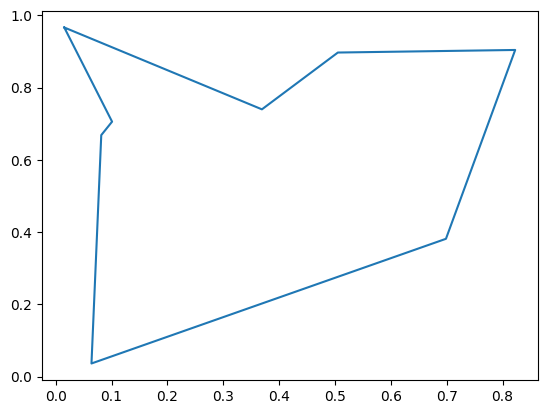

In [1474]:
## hopfield
plot(answer)

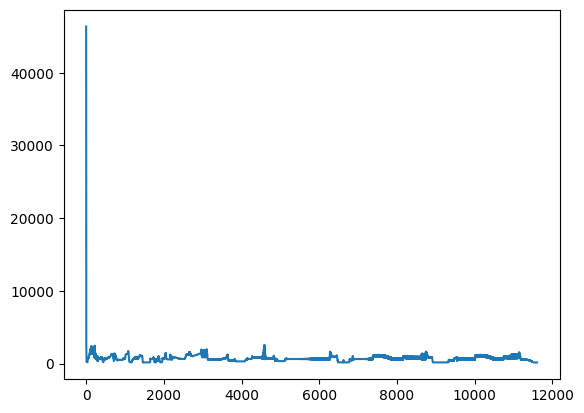

In [1475]:
## hopfield energy
plt.plot(energy)

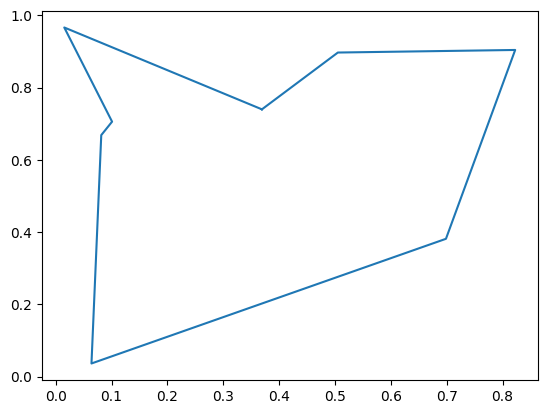

In [1476]:
## traverse
plot(traverse_perfect_path)

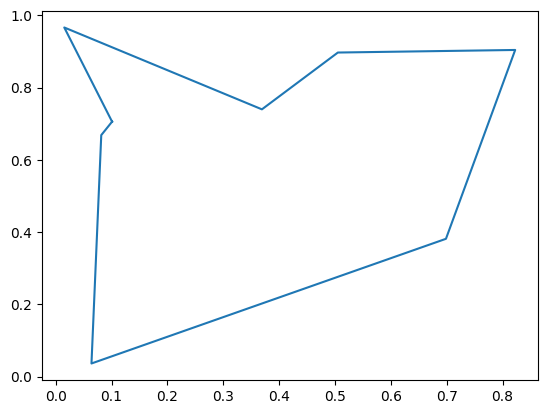

In [1477]:
## hopfield_SA
plot(perfect_path)

## 模拟退火-Hopfield实验

In [1444]:
list_N = [6,10,14,19,23,27]
# list_N = [3,4,5,6,7,8]
time_dict = {}
def cal_time(list_N):
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        N = list_N[i]
        cities = generate_cities(N)
        start = time.time()
        path_list = HopfieldSATSP(cities)()
        cities_list = cities.tolist()
        cities_plot_list = []
        for item in path_list:
            cities_plot_list.append(cities_list[item])
        end = time.time()
        cities_plot_list.append(cities_list[path_list[0]])
        ax.plot(*np.array(cities_plot_list).T)
        ax.set_title(f'N = {N} & time = {end-start:.2f}')
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
        time_dict[N] = end-start
        print('N = {}, time = {}'.format(N,end-start))
    plt.tight_layout()
    plt.savefig('time.png')

100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


N = 6, time = 87.79667115211487


100%|██████████| 200/200 [02:14<00:00,  1.48it/s]


N = 10, time = 135.00149488449097


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


N = 14, time = 204.57522702217102


100%|██████████| 200/200 [04:12<00:00,  1.26s/it]


N = 19, time = 252.8217577934265


100%|██████████| 200/200 [04:54<00:00,  1.47s/it]


N = 23, time = 294.85210967063904


100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


N = 27, time = 339.4254400730133


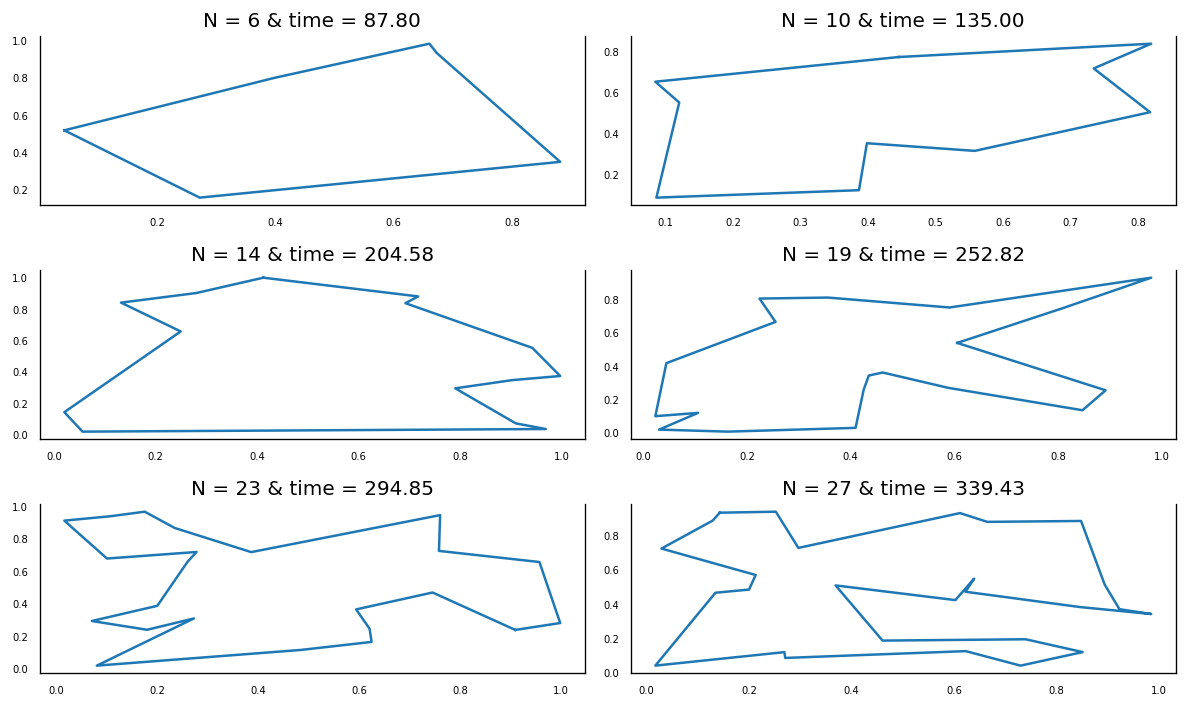

In [1445]:
cal_time(list_N)